In [14]:
import pandas as pd 
import numpy as np  
import scipy as sp  
import seaborn as sns
import gensim
from scipy import sparse
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
sns.set_style('darkgrid') 
import pickle       
import regex as re  
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
# Loads in the data into a Pandas data frame
fcc_csv = pd.read_csv('CSRIC_Best_Practices.csv')
fcc_csv.head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Public Safety and Disaster,Reference,cable,internet/Data,satellite,wireless,wireline,Service Provider,Network Operator,"Priority (1,2,3)",Equipment Supplier,Property Manager,Government,Public Safety
0,12-10-0436,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Service Provider; Network Operator; Public Saf...,Network Operations; Procedures;,True,NaN,True,True,True,True,True,True,True,2.0,False,False,False,True
1,12-10-0437,Highly Important,Network Operators and Service Providers should...,Internet/Data;,Service Provider; Network Operator;,Cyber Security; Network Operations; Network Pr...,False,NaN,False,True,False,False,False,True,True,2.0,False,False,False,False
2,12-10-0440,Highly Important,Network Operators and Service Providers should...,Internet/Data;,Service Provider; Network Operator;,Industry Cooperation; Network Operations;,False,NaN,False,True,False,False,False,True,True,2.0,False,False,False,False
3,12-10-0447,Important,Network Operators and Service Providers should...,Cable; Internet/Data; Satellite; Wireless; Wir...,Service Provider; Network Operator;,Liaison; Network Operations;,False,Note: This Best practice could impact 9-1-1 op...,True,True,True,True,True,True,True,1.0,False,False,False,False
4,12-10-0448,Highly Important,"Equipment Suppliers should where feasible, pr...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier;,Hardware; Network Elements; Network Provisioni...,False,NaN,True,True,True,True,True,False,False,2.0,True,False,False,False


In [16]:
# Here is a function for basic exploratory data analysis:
def eda(dataframe):
    # Replace any blank spaces w/ a underscore.
    dataframe.columns = dataframe.columns.str.replace(" ", "_")
    # Checks for the null values.
    print("missing values{}".format(dataframe.isnull().sum().sum()))
    # Checks the data frame range size.
    print("dataframe index: {}".format(dataframe.index))
    # Checks for data types of the columns within the data frame.
    print("dataframe types: {}".format(dataframe.dtypes))
    # Checks the shape of the data frame.
    print("dataframe shape: {}".format(dataframe.shape))
    # Gives us any statistical information of the data frame.
    print("dataframe describe: {}".format(dataframe.describe()))
    # Gives us the duplicated data of the data frame. 
    print("duplicates{}".format(dataframe[dataframe.duplicated()].sum()))
    # A for loop that does this for every single column & their 
    # values within our data frame giving us all unique values.
    for item in dataframe:
        print(item)
        print(dataframe[item].nunique()) 
    # Let's apply this function to our entire data frame.
eda(fcc_csv)

missing values778
dataframe index: RangeIndex(start=0, stop=1092, step=1)
dataframe types: BP_Number                      object
Priority                       object
Description                    object
Network_Type(s)                object
Industry_Role(s)               object
Keywords                       object
Public_Safety_and_Disaster       bool
Reference                      object
cable                            bool
internet/Data                    bool
satellite                        bool
wireless                         bool
wireline                         bool
Service_Provider                 bool
Network_Operator                 bool
Priority_(1,2,3)              float64
Equipment_Supplier               bool
Property_Manager                 bool
Government                       bool
Public_Safety                    bool
dtype: object
dataframe shape: (1092, 20)
dataframe describe:        Priority_(1,2,3)
count       1006.000000
mean           1.727634
std            

In [17]:
# Here's a function to convert NaN's in the data set to 'None' for 
# string objects.
# Just pass in the entire data frame.
def convert_str_nan(data):
    return data.astype(object).replace(np.nan, 'None', inplace = True).convert_str_nan(fcc_csv)

In [18]:
fcc_csv['Priority'].value_counts()

Important           465
Highly Important    350
Critical            191
Name: Priority, dtype: int64

In [19]:
# Let's rename the 'Priority_(1,2,3)' column so we can utilize it.
fcc_csv.rename(columns = {
    'Priority_(1,2,3)': 'Priorities'
},
inplace = True)# Let's view the values & how the correspond to the 'Priority' 
# column.
fcc_csv['Priorities'].value_counts()
# We notice that we have an unbalanced classification problem.
# Let's group the "Highly Important" (2) & "Critical" (3) aspects 
# because that's where we can make recommendations.
# Let's double check that it worked.
fcc_csv['Priorities'] = [0 if i == 1 else 1 for i in fcc_csv['Priorities']]
fcc_csv['Priorities'].value_counts()

1    627
0    465
Name: Priorities, dtype: int64

In [20]:
# Let's view the largest negative correlated columns to our  "Priorities" column.
largest_neg_corr_list = fcc_csv.corr()[['Priorities']].sort_values('Priorities').head(5).T.columns
print(largest_neg_corr_list)
# Let's view the largest positive correlated columns to our "Priorities" column.
largest_pos_corr_list = fcc_csv.corr()[['Priorities']].sort_values('Priorities').tail(5).T.columns.drop('Priorities')
print(largest_pos_corr_list)

Index(['Equipment_Supplier', 'Network_Operator', 'Government',
       'Property_Manager', 'Service_Provider'],
      dtype='object')
Index(['satellite', 'wireless', 'Public_Safety', 'Public_Safety_and_Disaster'], dtype='object')


In [21]:
# Let's pass in every column that is categorical into our X.
# These are the strongest & weakest correlated columns to our 
# "Priorities" variable. 
X = fcc_csv[['Network_Operator', 'Equipment_Supplier', 'Property_Manager', 'Service_Provider', 'wireline', 'wireless', 'satellite', 'Public_Safety']]
y = fcc_csv['Priorities'] 
# Our y is what we want to predict.# 
# We have to train/test split the data so we can model the data on 
# our training set & test it.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# We need to transpose the trains so they contain the same amount of rows.
X = X.transpose()

In [22]:
# Instantiates the Naive Bayes classifier.
mnb = MultinomialNB()
params = {'min_samples_split':[12, 25, 40]}
# Grid searches our Naive Bayes.
mnb_grid = {}
gs_mnb = GridSearchCV(mnb, param_grid = mnb_grid, cv = 3)
gs_mnb.fit(X_train, y_train)
gs_mnb.score(X_train, y_train)
# Scores the Naive Bayes.
gs_mnb.score(X_test, y_test)

0.5701219512195121

In [23]:
# Instantiates the random forest classifier.
rf = RandomForestClassifier(n_estimators = 10)
# Grid searches our random forest classifier.
gs_rf = GridSearchCV(rf, param_grid = params, return_train_score = True, cv = 5)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_train, y_train)
# Our random forest test score.
gs_rf.score(X_test, y_test)


0.6341463414634146

Ada Boost score on our train set : 0.6269633507853403
Ada Boost score on our test set : 0.6402439024390244


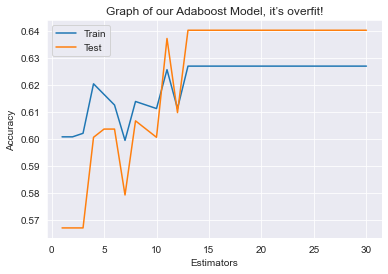

In [24]:
scores_test = []
scores_train = []
n_estimators = [] 
for n_est in range(30):
    ada = AdaBoostClassifier(n_estimators = n_est + 1, random_state = 42)
    ada.fit(X_train, y_train)
    n_estimators.append(n_est + 1)
    scores_test.append(ada.score(X_test, y_test))
    scores_train.append(ada.score(X_train, y_train))
# Our Ada Boost score on our train set.
print("Ada Boost score on our train set :", ada.score(X_train, y_train))
# Our Ada Boost score on our test set.
print("Ada Boost score on our test set :", ada.score(X_test, y_test))


# plot
fig, ax = pyplot.subplots()
ax.plot(n_estimators, scores_train, label='Train')
ax.plot(n_estimators, scores_test, label='Test')
ax.legend()
pyplot.xlabel('Estimators')
pyplot.ylabel('Accuracy')
pyplot.title('Graph of our Adaboost Model, it’s overfit!')
pyplot.show()

In [25]:
# example of dropout between fully connected layers
model_dropout = Sequential()
n_input = X_train.shape[1]
n_hidden = n_input
model_dropout.add(Dense(n_hidden, input_dim = n_input, activation = 'relu'))
model_dropout.add(Dropout(0.5)) 
# refers to nodes in the first hidden layer
model_dropout.add(Dense(1, activation = 'sigmoid'))
model_dropout.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
history_dropout = model_dropout.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = None)


Epoch 1/100
24/24 [==============================] - 4s 51ms/step - loss: 0.8310 - acc: 0.5249 - val_loss: 0.7102 - val_acc: 0.4543
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.8016 - acc: 0.4974 - val_loss: 0.6884 - val_acc: 0.5671
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.7584 - acc: 0.5223 - val_loss: 0.6798 - val_acc: 0.5823
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 0.7529 - acc: 0.5196 - val_loss: 0.6757 - val_acc: 0.6372
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 0.7430 - acc: 0.5275 - val_loss: 0.6729 - val_acc: 0.6037
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 0.7305 - acc: 0.5105 - val_loss: 0.6728 - val_acc: 0.6006
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 0.7041 - acc: 0.5510 - val_loss: 0.6710 - val_acc: 0.5884
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 0.

In [26]:
# Let's clean the data using Regex.
# Let's use regex to remove the words: service providers, equipment 
# suppliers, network operators, property managers, public safety
# Let's also remove any mention of any URLs.
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('(service providers|equipment suppliers|network operators|property managers|public safety)[s]?', ' ', x,  flags = re.I))

In [27]:
# This is a text preprocessing function that gets our data ready for 
# modeling & creates new columns for the 
# description text in their tokenized, lemmatized & stemmed forms. 
# This allows for easy selection of 
# different forms of the text for use in vectorization & modeling.
def preprocessed_columns(dataframe = fcc_csv, 
                        column = 'Description', 
                        new_lemma_column = 'lemmatized', 
                        new_stem_column = 'stemmed',
                        new_token_column = 'tokenized',
                        regular_expression = r'\w+'): 
    
    tokenizer = RegexpTokenizer(regular_expression)     
    lemmatizer = WordNetLemmatizer()                     
    stemmer = PorterStemmer()                            
    
    lemmatized = []                                      
    stemmed = []                                         
    tokenized = []
    
    
    for i in dataframe[column]:                        
        tokens = tokenizer.tokenize(i.lower())           
        tokenized.append(tokens)        
        lemma = [lemmatizer.lemmatize(token) for token in tokens]     
        lemmatized.append(lemma)                                              
        stems = [stemmer.stem(token) for token in tokens]            
        stemmed.append(stems)                                         
     
    dataframe[new_token_column] = [' '.join(i) for i in tokenized]    
    dataframe[new_lemma_column] = [' '.join(i) for i in lemmatized]   
    dataframe[new_stem_column] = [' '.join(i) for i in stemmed]   
    
    return dataframe
    
processed = preprocessed_columns(fcc_csv)

In [28]:
# Instantiate a CountVectorizer removing english stopwords, ngram range of unigrams & bigrams.
cv = CountVectorizer(stop_words ='english', ngram_range = (1,2), min_df = 25, max_df = .95) 
# Create a dataframe of our CV transformed tokenized words
count_array = cv.fit_transform(processed['tokenized']).toarray()
cv_df_token = pd.DataFrame(count_array,columns = cv.get_feature_names())
cv_df_token.fillna(0, inplace = True)
cv_df_token.head()


,access,address,analysis,applicable,applications,applies,applies ng9,appropriate,associated,authentication,...,traffic,training,unauthorized,use,used,user,users,using,wireless,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Split our data frame into really "important" & "not important" 
# columns.
# We will use the "really_important" descriptions to determine 
# severity & to give recommendations/analysis.
fcc_really_important = processed[processed['Priority'] == 1]
fcc_not_important = processed[processed['Priority'] == 0]
print(fcc_really_important.shape)
print(fcc_not_important.shape)

(0, 23)
(0, 23)


In [30]:
X_1 = processed['tokenized']
# We're train test splitting 3 different columns.
# These columns are the tokenized, lemmatized & stemmed from the processed dataframe.
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.3, stratify = y, random_state = 42)

In [31]:
# Le pipeline a pour objectif d'assembler plusieurs étapes 
# qui peuvent être validées de manière croisée tout en définissant différents paramètres.
# Convertissez une collection de documents texte en une matrice de nombres de jetons.
# Cette implémentation produit une représentation clairsemée des décomptes à l'aide de scipy.sparse.csr_matrix.
# La régression logistique ou modèle logit est un modèle de régression binomiale. 
# Comme pour tous les modèles de régression binomiale, 
# il s'agit de modéliser au mieux un modèle mathématique simple à des observations réelles nombreuses.

pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression())
])
params = {
    'lr__C':[0.6, 1, 1.2],
    'lr__penalty':["l1", "l2"],
    'cv__max_features':[None, 750, 1000, 1250],
    'cv__stop_words':['english', None],
    'cv__ngram_range':[(1,1), (1,4)]
}

In [32]:
# Our Logistic Regression Model.
gs_lr_tokenized_cv = GridSearchCV(pipe_cv, param_grid = params, cv = 5)
gs_lr_tokenized_cv.fit(X_1_train, y_train)
gs_lr_tokenized_cv.score(X_1_train, y_train)
gs_lr_tokenized_cv.score(X_1_test, y_test)

0.6737804878048781

In [33]:
gs_lr_tokenized_cv.best_params_

{'cv__max_features': None,
 'cv__ngram_range': (1, 4),
 'cv__stop_words': 'english',
 'lr__C': 1.2,
 'lr__penalty': 'l2'}

In [34]:
coefs = gs_lr_tokenized_cv.best_estimator_.steps[1][1].coef_
words = pd.DataFrame(zip(cv.get_feature_names(), np.exp(coefs[0])))
words = words.sort_values(1)


In [35]:
words

,0,1
87,place,0.853994
23,control,0.907809
26,critical network,0.907809
24,controls,0.907809
25,critical,0.907809
...,...,...
70,measures,1.046322
58,infrastructure,1.141106
57,information,1.141106
56,industry,1.141106
